In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/bilstm-ctc'

/content/drive/MyDrive/Colab Notebooks/bilstm-ctc


In [4]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
# tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
datafile = open('./Data/ICBOCR-D4/Train/Groundtruth.txt', encoding='utf8')
line = datafile.readline().split('@')[1].rstrip()
print(line, len("পিঞ্জরের"))
line = line.encode("unicode-escape").decode()
print(line, len(line))
print('প'+'ি'+'ঞ'+'্'+'জ'+'র'+'ে'+'র')

বনের পাখির চেয়ে পিঞ্জরের পাখিটাই বেশি ছটফট করে ! সুরেন্দ্র 8
\u09ac\u09a8\u09c7\u09b0 \u09aa\u09be\u0996\u09bf\u09b0 \u099a\u09c7\u09df\u09c7 \u09aa\u09bf\u099e\u09cd\u099c\u09b0\u09c7\u09b0 \u09aa\u09be\u0996\u09bf\u099f\u09be\u0987 \u09ac\u09c7\u09b6\u09bf \u099b\u099f\u09ab\u099f \u0995\u09b0\u09c7 ! \u09b8\u09c1\u09b0\u09c7\u09a8\u09cd\u09a6\u09cd\u09b0 298
পিঞ্জরের


In [5]:
train_datafile = open('./Data/ICBOCR-D4/Train/Groundtruth.txt', encoding='utf8')
test_datafile = open('./Data/ICBOCR-D4/Test/Groundtruth.txt', encoding='utf8')
train_lines = [line.rstrip() for line in train_datafile]
test_lines = [line.rstrip() for line in test_datafile]

train_image_dir = "./Data/ICBOCR-D4/Train/Line_Images/"
train_image_paths = [os.path.join(train_image_dir, line.split('@')[0]) for line in train_lines]
train_captions = [line.split('@')[1].lstrip() for line in train_lines]

test_image_dir = "./Data/ICBOCR-D4/Test/Line_Images/"
for i in range(len(test_lines)):
  try:
    train_captions.append(test_lines[i].split('@')[1].lstrip())
    train_image_paths.append(os.path.join(test_image_dir, test_lines[i].split('@')[0]))
  except:
    print(i+1, test_lines[i])

# for caption in train_captions:
#   print(caption)
print(len(train_image_paths), len(train_captions))
characters = set(char for label in train_captions for char in label)
print(len(characters), characters)

200 200
102 {'৭', 'ণ', 'h', 'ৎ', 'l', 'ম', 'উ', '।', 'f', '০', '’', 'n', 'ই', '!', 'ে', 'া', '২', 'g', '?', 'দ', 'অ', '.', '—', 'ঝ', 'ও', ' ', '-', 'গ', 'ু', 'ঠ', 'ঢ', 'ক', '\u200c', ';', '়', 'খ', '”', 'ৌ', '৩', 'ঙ', '৮', 'ো', 'ব', 'ভ', 'I', 'স', '\t', '–', 'ঞ', 'ট', '“', 'm', 'হ', 'i', 'L', 'ধ', 'ি', 'ড়', 'ং', 'চ', 'ঁ', 'ৃ', 'ত', 'r', 'প', '্', 'ঘ', 'য', 'ৰ', "'", 'e', '৫', 'ছ', 'শ', 'ল', 'y', 'এ', 'ঔ', 'o', 's', 'w', 'ঃ', 'জ', 'থ', ',', '৯', '১', '4', 'ূ', 'ড', 'ন', 'ফ', 'u', 'য়', 't', 'ী', 'v', 'ৈ', 'ষ', 'র', '"', 'আ'}


In [ ]:
f = open('./Dict/AllCharcaters.txt', encoding='utf-8')
lines = [line.rstrip().split(',')[1] for line in f]
lines = set(lines)
print(len(lines))
print(lines - characters)
print(characters-lines)
characters = lines.union(characters)
print(len(characters), characters)

84
{'ৎ', '—', 'ঙ', '৬', '•', 'ঋ', '০', 'ড', 'ৌ', '\u200d', 'ৗ', 'ঁ', 'ঐ', '॥', '\u200c', 'ঈ', 'ঃ', 'ং', 'ৰ', 'ঊ', '৮', '়', '১', '৪', '‘', '৭', '৯', 'ঔ', '২', 'ঢ', '৩', '৫', '\ufeff', 'ৱ', 'ৈ', 'ঢ়'}
{' ', '?', '!', ',', '-'}
89 {'?', 'া', '।', 'ঙ', 'চ', 'ু', 'আ', 'ঋ', '•', '০', 'ঝ', 'ূ', 'ঘ', '্', 'ো', 'ধ', 'য', 'ড', 'গ', 'ভ', 'অ', 'উ', 'ঐ', 'ঈ', 'ং', 'ৰ', '৮', 'প', 'স', 'খ', 'ট', '৪', '‘', 'ছ', 'ঠ', 'ষ', 'ঔ', '২', 'ঢ', 'ত', '\ufeff', 'ৱ', 'ৈ', 'ম', 'ৎ', ' ', 'ি', '—', '৬', 'ও', 'হ', 'ক', 'ে', 'শ', 'ৌ', 'য়', 'দ', '\u200d', 'ৗ', 'ল', 'জ', 'ঁ', 'থ', '!', 'ই', '॥', '\u200c', '-', 'ঃ', 'ী', 'ঊ', 'ড়', 'এ', '–', '়', 'ঞ', '১', '৭', '৯', 'র', 'ৃ', '৩', 'ব', '৫', 'ন', ',', 'ঢ়', 'ণ', 'ফ'}


In [6]:
# characters= lines
print("Number of images found: ", len(train_image_paths))
print("Number of labels found: ", len(train_captions))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 2452#224#2452
img_height = 144#224#144

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in train_captions])
print("Maximum length: ",max_length)

Number of images found:  200
Number of labels found:  200
Number of unique characters:  102
Characters present:  {'৭', 'ণ', 'h', 'ৎ', 'l', 'ম', 'উ', '।', 'f', '০', '’', 'n', 'ই', '!', 'ে', 'া', '২', 'g', '?', 'দ', 'অ', '.', '—', 'ঝ', 'ও', ' ', '-', 'গ', 'ু', 'ঠ', 'ঢ', 'ক', '\u200c', ';', '়', 'খ', '”', 'ৌ', '৩', 'ঙ', '৮', 'ো', 'ব', 'ভ', 'I', 'স', '\t', '–', 'ঞ', 'ট', '“', 'm', 'হ', 'i', 'L', 'ধ', 'ি', 'ড়', 'ং', 'চ', 'ঁ', 'ৃ', 'ত', 'r', 'প', '্', 'ঘ', 'য', 'ৰ', "'", 'e', '৫', 'ছ', 'শ', 'ল', 'y', 'এ', 'ঔ', 'o', 's', 'w', 'ঃ', 'জ', 'থ', ',', '৯', '১', '4', 'ূ', 'ড', 'ন', 'ফ', 'u', 'য়', 't', 'ী', 'v', 'ৈ', 'ষ', 'র', '"', 'আ'}
Maximum length:  75


In [7]:
def new_py_function(func, inp, Tout, name=None):
  def wrapped_func(*flat_inp):
    reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,expand_composites=True)
    out = func(*reconstructed_inp)
    return tf.nest.flatten(out, expand_composites=True)
  flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
  flat_out = tf.py_function(
      func=wrapped_func, 
      inp=tf.nest.flatten(inp, expand_composites=True),
      Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
      name=name)
  spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, 
                                   expand_composites=True)
  out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
  return out

def _dtype_to_tensor_spec(v):
  return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
  return v.dtype if isinstance(v, tf.TensorSpec) else v

In [8]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=''
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def label_to_tensor(st):
    f_list = list(characters)
    f_list.sort()
    st_list = []
    for s in st:
        s_index = f_list.index(s)
        st_list.append(s_index)
    return tf.convert_to_tensor(st_list, dtype=tf.float32)

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(train_image_paths), np.array(train_captions))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.image.per_image_standardization(img) # normalize data
    # 5. Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # label = label.numpy()
    label = tf.keras.preprocessing.sequence.pad_sequences([label.numpy()], maxlen=max_length, padding='post').squeeze()
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

def pad_map_fn(img_path, label):
    return new_py_function(encode_single_sample, inp=(img_path, label), Tout=({"image": tf.float32, "label": tf.int32}))

In [ ]:
sample_train_x, sample_train_y = [], []
for i in range(len(x_train)):
  sample = encode_single_sample(x_train[i], y_train[i])
  sample_train_x.append(np.asarray(sample['image']))
  label = np.asarray(sample['label'])
  label = np.expand_dims(label, -1)
  sample_train_y.append(label)
sample_train_x = np.asarray(sample_train_x)/255.0
sample_train_y = np.asarray(sample_train_y)
sample_train_y = np.expand_dims(sample_train_y, -1)

print(sample_train_x.shape)
print(sample_train_y.shape)

In [ ]:
y_train

In [9]:
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(
        pad_map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(batch_size)#.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = validation_dataset.map(
        pad_map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(batch_size)

dataset = train_dataset.take(1)
# list(dataset.as_numpy_iterator())
a = list(dataset.as_numpy_iterator())
for a in list(dataset.as_numpy_iterator()):
  print(a['image'].shape, a['label'].shape)

(16, 2452, 144, 3) (16, 75)


In [ ]:
# dataset = train_dataset.take(1)
# # list(dataset.as_numpy_iterator())
# a = list(dataset.as_numpy_iterator())
# a[0]['image'].shape, a[0]['label'].shape

((1, 2452, 144, 1), (1, 51))

In [ ]:
# ragged tensor
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).apply(tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size))


validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).apply(tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size))

dataset = train_dataset.take(1)
for a in list(dataset.as_numpy_iterator()):
  print(a['image'].shape)

(16, 2452, 144, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/ragged/ragged_tensor.py:2012: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(rows)


In [ ]:
plt.rc('font')
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    print(labels)
    for i in range(1):
        img = (images[i] * 255).numpy().astype("uint8")
        print(img.shape) # (200, 50, 1)
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode()
        plt.imshow(img[:, :, 0].T, cmap="gray")
        plt.title(label)
        plt.axis("off")
plt.show()

In [ ]:
###### TEST EXAMPLE
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.Bidirectional(layers.LSTM(512, return_sequences=True, dropout=0.25))
linear_layer = layers.Dense(512, activation="relu", name="dense1")
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)
print(paragraph1.shape, output.shape, linear_layer(paragraph1).shape)

(20, 10, 50) (20, 10, 1024) (20, 10, 512)


In [10]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length =  tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        # print(y_true.shape, y_pred.shape)
        # batch_len =  nrows(y_true, 'int64')
        # input_length = y_pred.uniform_row_length
        # label_length = y_true.uniform_row_length

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length) + 0.01
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

    # def loss(self, y_true, y_pred):
    #     """The actual loss"""

    #     batch_labels = y_true[:, :, 0]
    #     label_length = y_true[:, 0, 1]
    #     input_length = y_true[:, 0, 2]

    #     #reshape for the loss, add that extra dimension
    #     label_length = tf.expand_dims(label_length, -1)
    #     input_length = tf.expand_dims(input_length, -1)

    #     # use keras backend function for the loss
    #     return keras.backend.ctc_batch_cost(batch_labels, y_pred, input_length, label_length)


def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 3), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    x = tf.keras.applications.MobileNetV2(include_top=False,weights="imagenet",input_tensor=input_img)(input_img)
    
    new_shape = (77*5, 1280)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    # new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    # x = layers.Dense(1024, activation="relu", name="dense1")(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation="relu", name="dense5")(x)
    x = layers.Dropout(0.2)(x)
    # x = layers.Dense(64, activation="relu", name="dense2")(x)
    # x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    # x = layers.Bidirectional(layers.LSTM(512, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 2, activation="softmax", name="dense3")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 2452, 144, 3 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 77, 5, 1280)  2257984     image[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 385, 1280)    0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
dense5 (Dense)                  (None, 385, 512)     655872      reshape[0][0]                    
________________________

In [11]:
epochs = 500
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
# history = model.fit(
#     x=[sample_train_x, sample_train_y], 
#     y=sample_train_y, 
#     batch_size=batch_size,
#     validation_split=0.1,
#     epochs=epochs
# )

checkpoint_filepath = 'checkpoint/mobilenet/cp.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', verbose=1,
    save_best_only=True)

# model.load_weights(checkpoint_filepath)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/500
12/12 [==============================] - 75s 3s/step - loss: 1174.4093 - val_loss: 347.9620

Epoch 00001: val_loss improved from inf to 347.96198, saving model to checkpoint/mobilenet/cp.ckpt
Epoch 2/500
12/12 [==============================] - 13s 1s/step - loss: 340.2082 - val_loss: 324.8961

Epoch 00002: val_loss improved from 347.96198 to 324.89606, saving model to checkpoint/mobilenet/cp.ckpt
Epoch 3/500
12/12 [==============================] - 13s 1s/step - loss: 299.6862 - val_loss: 269.7519

Epoch 00003: val_loss improved from 324.89606 to 269.75189, saving model to checkpoint/mobilenet/cp.ckpt
Epoch 4/500
12/12 [==============================] - 13s 1s/step - loss: 262.6338 - val_loss: 255.5472

Epoch 00004: val_loss improved from 269.75189 to 255.54721, saving model to checkpoint/mobilenet/cp.ckpt
Epoch 5/500
12/12 [==============================] - 13s 1s/step - loss: 247.6657 - val_loss: 247.6996

Epoch 00005: val_loss improved from 255.54721 to 247.69962, savin

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2452, 144, 1)]    0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 2452, 144, 32)     320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 1226, 72, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 1226, 72, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 613, 36, 64)       0         
_________________________________________________________________
reshape (Reshape)            (None, 613, 2304)         0         
_________________________________________________________________
dense1 (Dense)               (None, 613, 512)          118016

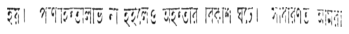

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense3").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=False, beam_width=100)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)
    for i in range(1):
        img = (batch_images[i] * 255).numpy().astype("uint8")
        # print(img.shape) # (200, 50, 1)
        plt.imshow(img[:, :, 0].T, cmap="gray")
        plt.axis("off")
plt.show()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2452, 144, 1)]    0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 2452, 144, 32)     320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 1226, 72, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 1226, 72, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 613, 36, 64)       0         
_________________________________________________________________
reshape (Reshape)            (None, 613, 2304)         0         
_________________________________________________________________
dense1 (Dense)               (None, 613, 512)          1180

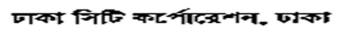

In [ ]:
test_datafile = open('./Data/ICBOCR-D4/custom-images/Groundtruth.txt', encoding='utf8')
test_lines = [line.rstrip() for line in test_datafile]

test_image_dir = "./Data/ICBOCR-D4/custom-images/Line_images/"
test_image_paths = [os.path.join(test_image_dir, line.split('@')[0]) for line in test_lines]
test_captions = [line.split('@')[1].lstrip() for line in test_lines]


x_test, _, y_test, _ = split_data(np.array(test_image_paths), np.array(test_captions), train_size=1.0, shuffle=True)

batch_size = 1
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(batch_size)#.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=False, beam_width=100)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)
    for i in range(1):
        img = (batch_images[i] * 255).numpy().astype("uint8")
        # print(img.shape) # (200, 50, 1)
        plt.imshow(img[:, :, 0].T, cmap="gray")
        plt.axis("off")
plt.show()
